In [1]:
import string

import numpy as np
import pandas as pd
import plotly.express as px
from numpy.random import RandomState

from src.extraction.jsonl_data_reader import JsonlDataReader

In [2]:
seed = 7
random_state = RandomState(seed=seed)
np.random.seed(seed)

In [3]:
train_data = JsonlDataReader(file_name='train.jsonl').read()
dev_data = JsonlDataReader(file_name='dev.jsonl').read()
test_data = JsonlDataReader(file_name='test.jsonl').read()

In [5]:
from src.preprocessing.simple_preprocessor import SimplePreprocessor

preprocessor = SimplePreprocessor(remove_citations=True, remove_duplicates=True)
preprocessed_train = preprocessor.preprocess(train_data)
preprocessed_dev = preprocessor.preprocess(dev_data)
preprocessed_test = preprocessor.preprocess(test_data)

In [6]:
from src.tokenize.spacy_tokenizer import SpacyTokenizer

tokenizer = SpacyTokenizer(replace_numbers=True, remove_stopwords=False, merge_nouns=False, merge_entities=False, lemmatize=False)
tokenized_train = tokenizer.tokenize(train_data)
tokenized_dev = tokenizer.tokenize(preprocessed_dev)
tokenized_test = tokenizer.tokenize(test_data)

In [5]:
from src.tokenize.null_tokenizer import NullTokenizer

tokenizer = NullTokenizer()
tokenized_train = tokenizer.tokenize(preprocessed_train)
tokenized_dev = tokenizer.tokenize(preprocessed_dev)
tokenized_test = tokenizer.tokenize(preprocessed_test)

In [49]:
from src.tokenize.sentence_piece_tokenizer import SentencePieceTokenizer
tokenizer = SentencePieceTokenizer(vocab_size=20000)
tokenizer.fit(preprocessed_train)
tokenized_train = tokenizer.tokenize(preprocessed_train)
tokenized_dev = tokenizer.tokenize(preprocessed_dev)
tokenized_test = tokenizer.tokenize(preprocessed_test)

In [8]:
from src.vectorizer.sk_count_vectorizer import SkCountVectorizer
from src.vectorizer.sk_tfidf_vectorizer import SkTfidfVectorizer
# token_pattern=f'[{string.ascii_letters}{string.digits}]+'

vectorizer = SkTfidfVectorizer(
    ngram_range=(1, 2), ignore_preprocessing=False,
    analyzer='word', binary=True
)
vectorizer.fit(tokenized_train)
vectorized_train = vectorizer.transform(tokenized_train)
vectorized_dev = vectorizer.transform(tokenized_dev)
vectorized_test = vectorizer.transform(tokenized_test)

In [10]:
# len(vectorizer.model.vocabulary_)

438428

In [31]:
from src.vectorizer.sk_tfidf_vectorizer import SkTfidfVectorizer


vectorizer1 = SkCountVectorizer(
    ignore_preprocessing=False, 
    ngram_range=(1, 2), analyzer='word',
    binary=True
)

vectorizer1.fit(tokenized_train)
vectorized_train1 = vectorizer1.transform(tokenized_train)
vectorized_test1 = vectorizer1.transform(tokenized_test)
len(vectorizer1.model.vocabulary_)

161090

In [32]:
vectorized_train1.vectors

<8243x161090 sparse matrix of type '<class 'numpy.int64'>'
	with 451336 stored elements in Compressed Sparse Row format>

In [33]:
from src.vectorizer.sk_tfidf_vectorizer import SkTfidfVectorizer

vectorizer2 = SkTfidfVectorizer(
    ignore_preprocessing=False,
    ngram_range=(1, 2), analyzer='word',
    binary=True
)

vectorizer2.fit(tokenized_train)
vectorized_train2 = vectorizer2.transform(tokenized_train)
vectorized_test2 = vectorizer2.transform(tokenized_test)
len(vectorizer2.model.vocabulary_)

161090

In [34]:
from src.schema.vectorized_data import VectorizedData
import scipy

vectorized_train = VectorizedData(scipy.sparse.hstack([vectorized_train1.vectors, vectorized_train2.vectors]), vectorized_train1.id, vectorized_train1.labels)
vectorized_test = VectorizedData(scipy.sparse.hstack([vectorized_test1.vectors, vectorized_test2.vectors]), vectorized_test1.id, vectorized_test1.labels)

In [38]:
from src.vectorizer.sk_tfidf_vectorizer import SkTfidfVectorizer

vectorizer = SkTfidfVectorizer(
    ignore_preprocessing=False,
    ngram_range=(1, 2), analyzer='word',
    binary=True
)

vectorizer.fit(tokenized_train)
vectorized_train = vectorizer.transform(tokenized_train)
vectorized_test = vectorizer.transform(tokenized_test)
len(vectorizer.model.vocabulary_)

161090

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support

model = LogisticRegression(max_iter=2000, C=10)
model.fit(vectorized_train.vectors, vectorized_train.label_indices)
y_pred_train = model.predict(vectorized_train.vectors)
training_score = f1_score(vectorized_train.label_indices, y_pred_train, average='macro')
print(f'{training_score=}')
print(confusion_matrix(vectorized_train.label_indices, y_pred_train))
print(precision_recall_fscore_support(vectorized_train.label_indices, y_pred_train, average='macro'))

y_pred_dev = model.predict(vectorized_dev.vectors)
dev_score = f1_score(vectorized_dev.label_indices, y_pred_dev, average='macro')
print(f'{dev_score=}')
print(confusion_matrix(vectorized_dev.label_indices, y_pred_dev))
print(precision_recall_fscore_support(vectorized_dev.label_indices, y_pred_dev, average='macro'))

y_pred_test = model.predict(vectorized_test.vectors)
testing_score = f1_score(vectorized_test.label_indices, y_pred_test, average='macro')
print(f'{testing_score=}')
print(confusion_matrix(vectorized_test.label_indices, y_pred_test))
print(precision_recall_fscore_support(vectorized_test.label_indices, y_pred_test, average='macro'))

training_score=0.9978193880384293
[[4834    5    1]
 [   5 2289    0]
 [   5    0 1104]]
(0.9982836713639273, 0.9973573884495986, 0.9978193880384293, None)
dev_score=0.8157982330311194
[[487  34  17]
 [ 57 192   6]
 [ 24   6  93]]
(0.8289015703415897, 0.8047477328042468, 0.8157982330311194, None)
testing_score=0.8241645391110555
[[870  62  65]
 [102 479  24]
 [ 33   7 219]]
(0.8169327313569607, 0.8366377454368701, 0.8241645391110555, None)


In [55]:
from scipy.sparse import csr_matrix
import shap

explainer = shap.Explainer(
    model, csr_matrix.todense(vectorized_train.vectors), feature_names=vectorizer.model.get_feature_names_out()
)
shap_values = explainer(csr_matrix.todense(vectorized_test.vectors))

In [13]:
shap_values.shape

(1861, 161090, 3)

In [58]:
shap.plots.text(shap_values[:, :, 0])

ValueError: The length of the attribution values must match the number of tokens if shap_values.clustering is None! When passing hierarchical attributions the clustering is also required.

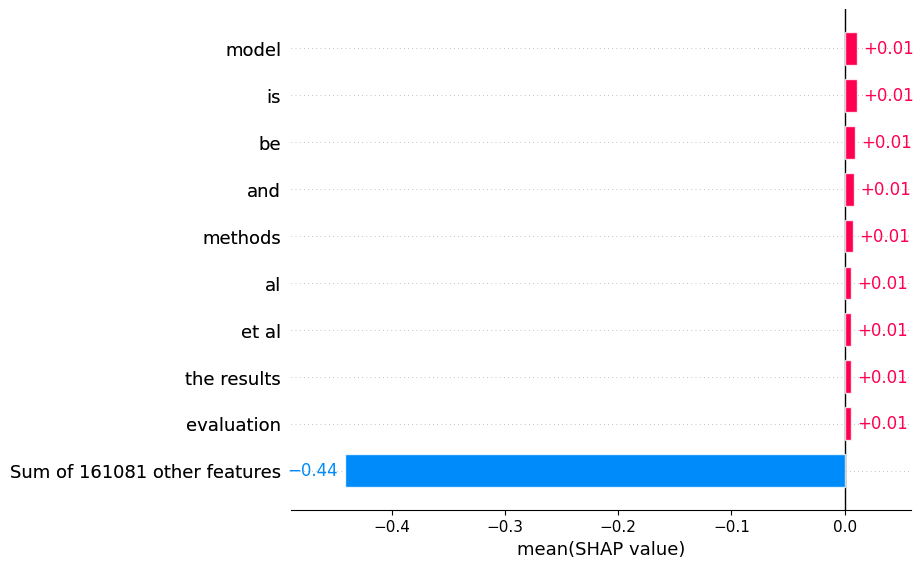

In [33]:
shap.plots.bar(shap_values[:, :, 0].mean(0), order=shap.Explanation.argsort.flip)

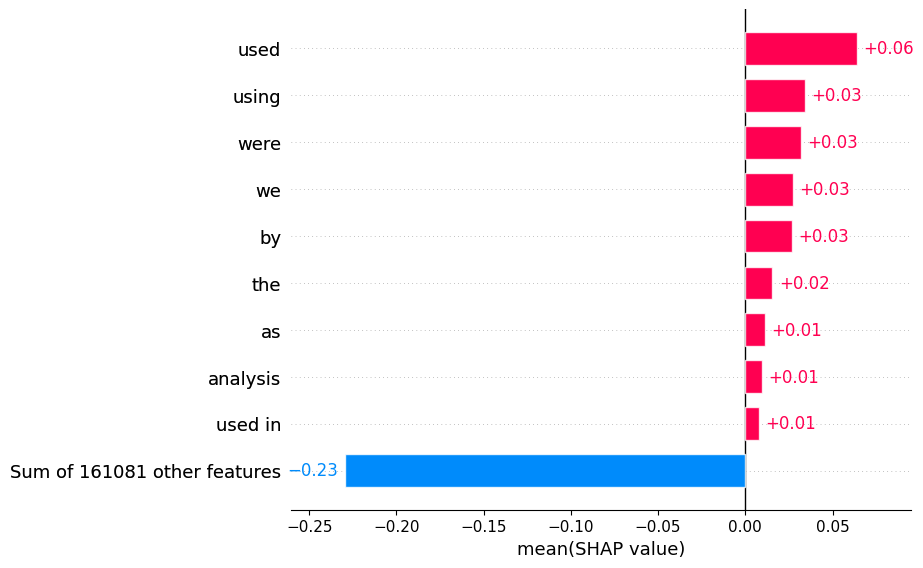

In [35]:
shap.plots.bar(shap_values[:, :, 1].mean(0), order=shap.Explanation.argsort.flip)

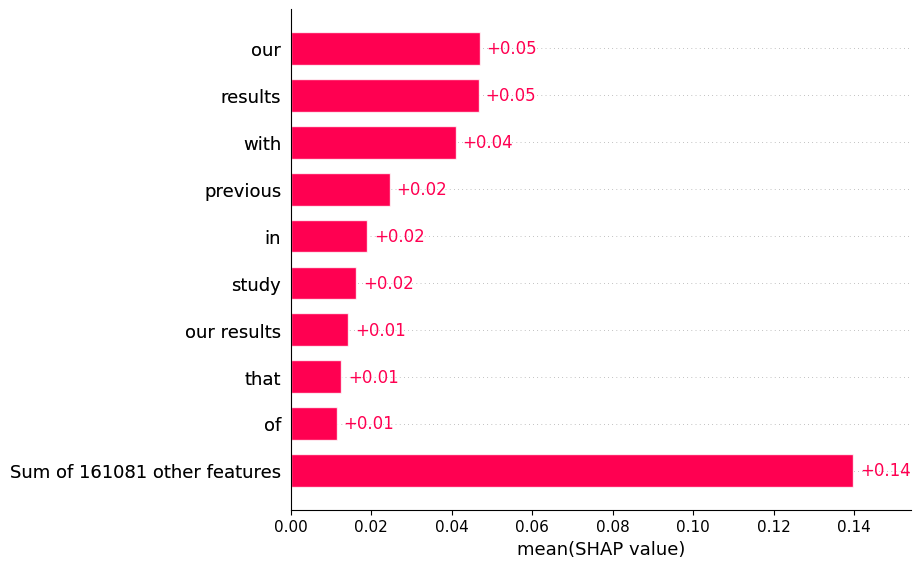

In [79]:
shap.plots.bar(shap_values[:, :, 2].mean(0), order=shap.Explanation.argsort.flip)

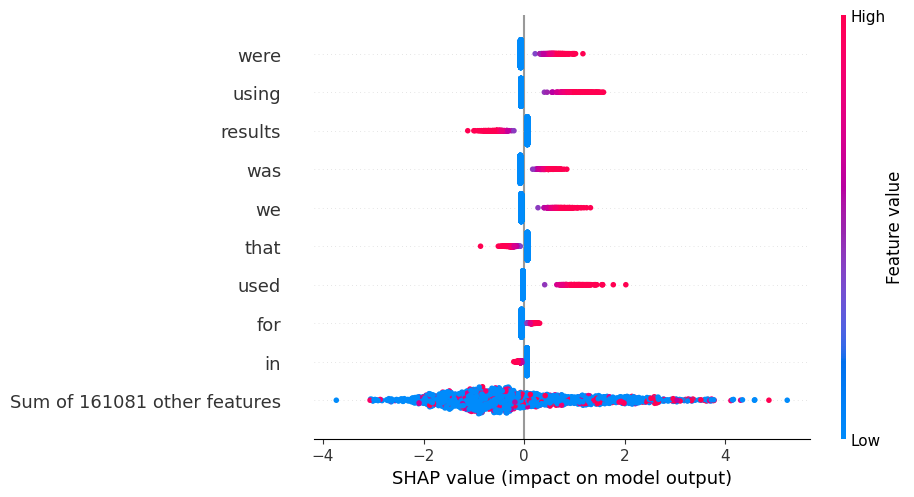

In [27]:
shap.plots.beeswarm(shap_values[:, :, 1])

In [69]:
kernel_explainer = shap.KernelExplainer(model.predict, shap.sample(np.asarray(csr_matrix.todense(vectorized_train.vectors))), feature_names=vectorizer.model.get_feature_names_out())
shap_vals = kernel_explainer.shap_values(np.asarray(csr_matrix.todense(vectorized_test.vectors[0])))

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
shap.plots.waterfall(shap_values[0, :, 0])

In [ ]:
shap.plots.force(shap_values[:, :, 0])

Try LIME

In [89]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
num_features = len(vectorizer.model.get_feature_names_out())
c = make_pipeline(vectorizer.model, model)

In [88]:
len(vectorizer.model.get_feature_names_out())

161090

In [92]:
from src.schema.tokenized_data import TokenizedData

sampled_token = ' '.join(tokenized_train.tokens[0])

In [94]:
print(c.predict_proba([sampled_token]).round(3))

[[0.929 0.051 0.019]]


In [95]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['background', 'method', 'result'])

In [96]:
exp = explainer.explain_instance(sampled_token, c.predict_proba, num_features=num_features, labels=[0])

In [97]:
exp.as_list(label=0)

[('were', -0.11797939209401478),
 ('interacts', 0.0456488467834114),
 ('each', -0.044828568085569336),
 ('cluster', 0.03881135630308705),
 ('remains', 0.037211584031579356),
 ('biosynthesis', 0.03646308871009266),
 ('with', -0.03372888960061043),
 ('unclear', 0.0285451857632877),
 ('direct', 0.028248336526807295),
 ('however', 0.02803757611520004),
 ('as', -0.02672343592737873),
 ('reported', 0.026248496869254543),
 ('or', 0.026160276355705645),
 ('the', -0.02603825268961537),
 ('isd11', 0.025257451736235077),
 ('interactions', 0.02321120894019704),
 ('how', 0.02182598576609474),
 ('frataxin', 0.021778417903666025),
 ('iscu', 0.021477443649254704),
 ('iscs', 0.01996840418267555),
 ('isu1', 0.016307022743596463),
 ('components', 0.009091511490122385),
 ('to', -0.008995749504051785),
 ('component', -0.006342403392749375),
 ('fe', 0.0021673256450362925),
 ('_like_num_', -0.001954689504786953),
 ('s', 0.00097894556325762)]

In [100]:
exp.save_to_file('test.html', labels=[0], predict_proba=True, show_predicted_value=True)

In [ ]:
exp.show_in_notebook(text=True)

In [21]:
fail_cases = []

for idx, (actual_y, pred_y) in enumerate(zip(vectorized_test.label_indices, y_pred_test)):
    if actual_y == 1 and pred_y == 0:
        fail_cases.append(idx)

In [22]:
fail_cases

[5,
 9,
 16,
 19,
 32,
 41,
 47,
 59,
 67,
 91,
 100,
 129,
 130,
 134,
 145,
 152,
 165,
 188,
 203,
 204,
 208,
 221,
 237,
 238,
 249,
 257,
 265,
 293,
 356,
 363,
 372,
 384,
 395,
 402,
 424,
 425,
 430,
 469,
 489,
 501,
 517,
 524,
 533,
 535,
 560,
 581,
 587,
 645,
 647,
 655,
 662,
 666,
 667,
 668,
 683,
 695,
 704,
 705,
 707,
 723,
 736,
 747,
 796,
 808,
 812,
 818,
 819,
 823,
 833,
 834,
 841,
 866,
 873,
 896,
 900,
 922,
 927,
 934,
 950,
 954,
 975,
 979,
 988,
 1011,
 1014,
 1026,
 1034,
 1052,
 1058,
 1063,
 1085,
 1100,
 1116,
 1132,
 1139,
 1152,
 1176,
 1184,
 1213,
 1219,
 1241,
 1246,
 1250,
 1274,
 1278,
 1314,
 1317,
 1326,
 1333,
 1336,
 1341,
 1353,
 1376,
 1391,
 1395,
 1406,
 1415,
 1426,
 1442,
 1447,
 1483,
 1503,
 1515,
 1564,
 1588,
 1599,
 1604,
 1633,
 1641,
 1648,
 1657,
 1669,
 1675,
 1692,
 1701,
 1707,
 1709,
 1738,
 1745,
 1798,
 1803,
 1809,
 1817,
 1829,
 1846,
 1852,
 1860]

In [25]:
failure_text = [preprocessed_train.texts[idx] for idx in fail_cases]
failure_text

['Recent studies identified Wee1 as a potential molecular target in cancer cells and the selective small molecule Wee1-inhibitor MK-1775 demonstrated promising results in cancer cells with enhanced levels of Wee1 .',
 'Currently, with advances in radiotherapeutic, chemotherapeutic, and surgical techniques, limb-salvage surgery has become an accepted treatment .',
 'Consistent with previous reports (al-Khodairy et al., 1995; ; Tanaka et al., 1999; Biggins et al., 2001), our data showed that Smt3 and Ubc9 have pivotal functions during mitosis.',
 'Previous empirical analyses of subnational consumer subsidies found that a majority of solar adoption was attributable to subsidies (e.g., Hughes and Podolefsky, 2015; Burr, 2016; De Groote and Verboven, 2016; ).',
 'More examples of contradictory results have been observed in bovines; some reports  indicated a significant decrease in blastocyst',
 'has been undertaken at several locations including the Ganges delta of southern Bangladesh (Wang

In [10]:
[term for term in vectorizer.model.vocabulary_ if term.isdigit()]

['11',
 '16',
 '14',
 '15',
 '13',
 '1982',
 '1988',
 '12',
 '1964',
 '2007',
 '340',
 '1995',
 '1999',
 '2001',
 '2015',
 '2016',
 '2004',
 '2006',
 '1984',
 '1986',
 '1720',
 '1993',
 '1998',
 '2000',
 '2005',
 '54',
 '55',
 '2010',
 '2013',
 '1979',
 '24',
 '21',
 '1997',
 '2009',
 '2008',
 '2011',
 '2003',
 '2014',
 '1991',
 '1996',
 '1989',
 '20',
 '000',
 '200304',
 '10',
 '36',
 '42',
 '397',
 '2002',
 '383',
 '697',
 '41',
 '38',
 '64',
 '39',
 '40',
 '19',
 '23',
 '0100',
 '34',
 '1987',
 '1992',
 '1983',
 '44',
 '17',
 '003',
 '18',
 '30',
 '28',
 '4452',
 '25',
 '26',
 '27',
 '80',
 '105',
 '66',
 '95',
 '3060',
 '60',
 '158',
 '812',
 '043',
 '100',
 '07',
 '1821',
 '880',
 '31',
 '32',
 '33',
 '0111',
 '1990',
 '200300',
 '50',
 '65',
 '00075',
 '127',
 '129',
 '61',
 '130',
 '102',
 '2017',
 '008',
 '2012',
 '201214',
 '99',
 '85',
 '43',
 '1379',
 '51',
 '13751387',
 '1980',
 '200607',
 '0019',
 '1994',
 '600',
 '550',
 '1127',
 '05',
 '02',
 '01',
 '59',
 '180',
 '68',


In [ ]:
def containing_digit(sentence: str) -> list[str]:
    return [word for word in sentence.split() if word.isdigit()]
digit_occurrence = [containing_digit(sentence) for sentence in preprocessed_train.texts]
digit_occurrence

In [19]:
compile_digit_occurrences = list(zip(digit_occurrence, preprocessed_train.label_indices))
counter = dict()
for digits, y_value in compile_digit_occurrences:
    for digit in digits:
        counter.setdefault(digit, {0: 0, 1: 0, 2: 0})
        counter[digit][y_value] += 1

In [21]:
digit_class_counts = pd.DataFrame(counter).transpose()
digit_class_counts

,0,1,2
11,11,4,5
13,11,5,0
340,0,1,0
2,98,55,9
4,31,29,7
...,...,...,...
512,0,1,0
341,0,1,0
014,1,0,0
93,1,0,0


In [25]:
digit_counts = digit_class_counts.sum(axis=1).reset_index()
filtered_counts = digit_counts[digit_counts[0] > 10]
filtered_counts

,index,0
0,11,20
1,13,16
3,2,162
4,4,67
7,24,19
10,10,68
11,3,88
18,5,74
19,1,176
20,18,23


In [27]:
digit_class_counts.merge(filtered_counts.set_index('index'), left_index=True, right_index=True)

,0_x,1,2,0_y
11,11,4,5,20
13,11,5,0,16
2,98,55,9,162
4,31,29,7,67
24,10,7,2,19
10,31,31,6,68
3,47,29,12,88
5,40,29,5,74
1,103,55,18,176
18,12,8,3,23


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

model = LogisticRegression(max_iter=2000, class_weight='balanced')
model.fit(vectorized_train.vectors, vectorized_train.label_indices)
y_pred_train = model.predict(vectorized_train.vectors)
training_score = f1_score(vectorized_train.label_indices, y_pred_train, average='macro')
print(f'{training_score=}')
display(confusion_matrix(vectorized_train.label_indices, y_pred_train))

y_pred_test = model.predict(vectorized_test.vectors)
testing_score = f1_score(vectorized_test.label_indices, y_pred_test, average='macro')
print(f'{testing_score=}')
display(confusion_matrix(vectorized_test.label_indices, y_pred_test))

training_score=0.9772618256745885


array([[4706,   99,   35],
       [  36, 2249,    9],
       [   0,    0, 1109]], dtype=int64)

testing_score=0.7609316463090018


array([[727,  89, 181],
       [ 61, 492,  52],
       [ 15,   7, 237]], dtype=int64)